# Exploring Beer through reviews

[Beer Advocate](https://data.world/petergensler/beer-advocate-reviews) is a dataset containing ~500k reviews of beers.

In [8]:
!pip install git+https://github.com/lambdaofgod/textrank
!pip install python-igraph

  Cloning https://github.com/lambdaofgod/textrank to /tmp/pip-req-build-9ccxddjf
  Running setup.py bdist_wheel for summa ... - done
  Stored in directory: /tmp/pip-ephem-wheel-cache-i8byeo3u/wheels/a2/a7/6c/30b35a30a820a7c1e939b4aef4db882923377c0e56ca24e338
Successfully built summa
    100% |████████████████████████████████| 378kB 7.5MB/s 
  Running setup.py bdist_wheel for python-igraph ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

In [0]:
from operator import itemgetter
from concurrent.futures import ProcessPoolExecutor 

import igraph
import summa
import pandas as pd

import itertools

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline


from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder

In [0]:
lemmatizer = WordNetLemmatizer()


def stem(text):
    return lemmatizer.lemmatize(text)


def map_parallel(f, iterable, **kwargs):
    with ProcessPoolExecutor() as pool:
        result = pool.map(f, iterable, **kwargs)
    return result


def retrieve_articles(start, chunksize=1000):
    return arxiv.query(
        search_query=search_query,
        start=start,
        max_results=chunksize
    )

In [0]:
def vectorize_text(examples_df):

    vectorizer = CountVectorizer(min_df=2)
    vectorized_data = vectorizer.fit_transform(examples_df['summary'])

    le = LabelEncoder()
    ohe = OneHotEncoder()
    categories_labels = le.fit_transform(valid_example_categories).reshape(-1, 1)
    categories_ohe = ohe.fit_transform(categories_labels).todense()
    return (vectorized_data, categories_labels, categories_ohe), (ohe, le)


def extract_keywords(text):
    """
    Use gensim's textrank-based approach
    """
    return summa.keywords.keywords(
        text=text,
        split=True
    )

In [12]:
%%time

beer_df = pd.read_csv('https://query.data.world/s/ybcjhzas3vxtitpe6lxkxpdrthxc7t')

CPU times: user 6.98 s, sys: 1.84 s, total: 8.82 s
Wall time: 17.5 s


## Basic info

In [13]:
beer_df.shape

(528870, 13)

In [14]:
beer_df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_aroma', 'review_overall', 'review_palate',
       'review_profileName', 'review_taste', 'review_text', 'review_time'],
      dtype='object')

### Unique revievers

In [15]:
len(beer_df['review_profileName'].unique())

22801

### Styles

Number of styles

In [16]:
styles = beer_df['beer_style'].unique()
len(styles)

104

In [17]:
beer_df['beer_style'].value_counts()

American IPA                           43369
American Double / Imperial IPA         26106
American Double / Imperial Stout       23354
American Pale Ale (APA)                20520
American Amber / Red Ale               18731
Russian Imperial Stout                 17192
American Porter                        16601
Belgian Strong Dark Ale                15407
Fruit / Vegetable Beer                 15148
Witbier                                13535
Tripel                                 11637
American Barleywine                    10108
American Adjunct Lager                  9613
Belgian Strong Pale Ale                 8796
Hefeweizen                              8553
English Pale Ale                        7953
American Stout                          7868
Saison / Farmhouse Ale                  7835
American Pale Wheat Ale                 7771
American Strong Ale                     7458
Dubbel                                  7270
Märzen / Oktoberfest                    7012
American B

## Reviews

In [0]:
review_texts = beer_df['review_text'].dropna()

In [19]:
%%time
text_lengths = review_texts.str.split().apply(len)

CPU times: user 13.2 s, sys: 3.53 s, total: 16.7 s
Wall time: 16.7 s


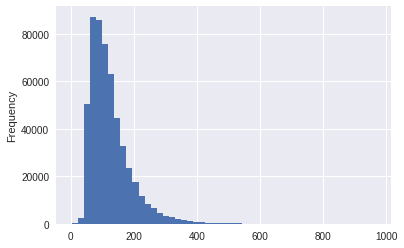

In [20]:
text_lengths.plot.hist(bins=50);

## Keywords

In [23]:
%%time

example_review_keywords = pd.Series(list(map_parallel(extract_keywords, review_texts.loc[:10000])))

CPU times: user 3.86 s, sys: 526 ms, total: 4.38 s
Wall time: 48.6 s


In [24]:
example_review_keywords

0                                                [lactic]
1                                 [light, red, drinkable]
2                                   [light, roast, black]
3                                     [good, fresh, note]
4       [beer, cauldron, brass, copper, citrus, profil...
5       [definitely, finish, like, liked, white, head,...
6       [ginger, nice, simple, aromas, beer, caramel, ...
7       [light, malt, beer, beers, white, summer, soun...
8              [cheap, golden, head, good, normal, lager]
9       [lager, lagers, mysterious, dense, hop, soft, ...
10      [beer, taste, tasting, macro, straw, thing, as...
11      [white, ale, beer, aroma sharply, clear, taste...
12               [light, honey, good, ginger, fruitiness]
13      [good, beer, belgium, golden, white, trade, re...
14                  [lacking, flavor, flavors, chocolate]
15      [quality, bacterial, tap, taps, ashland, doesn...
16      [light, tasted, taste, orange, bitter, aggress...
17      [smoke

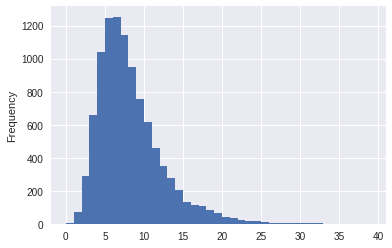

In [25]:
example_keyword_lengths = example_review_keywords.apply(len)
max_keywords_length = example_keyword_lengths.max()
example_keyword_lengths.plot.hist(bins=max_keywords_length);